# Triangle Load on a Simply-Supported Beam and Comparison with Semi-Analytic Solution

In [13]:
import numpy as np

L, w, h = 1000.0, 20.0, 80.0  # geometry
Ex, nu = 210000.0, 0.25  # material

Iy = h * w**3 / 12
Iz = w * h**3 / 12
Ix = (Iy + Iz) / 2
A = w * h
EI = Ex * Iz
G = Ex / (2 * (1 + nu))
GA = G * A * 5 / 6

qy_max = 1.0  # max intensity of the load

In [14]:
dfdx = 4 * qy_max / L


def qy(x):
    if isinstance(x, (int, float)):
        if x < L / 4:
            return 0.0
        elif (x >= L / 4) and (x < L / 2):
            return x * dfdx - qy_max
        elif (x >= L / 2) and (x < 3 * L / 4):
            return qy_max - (x - L / 2) * dfdx
        elif x >= 3 * L / 4:
            return 0.0
    else:
        res = np.zeros_like(x)
        where = np.where((x >= L / 4) & (x < L / 2))[0]
        res[where] = x[where] * dfdx - qy_max
        where = np.where((x >= L / 2) & (x < 3 * L / 4))[0]
        res[where] = qy_max - (x[where] - L / 2) * dfdx
        return res

## Finite Element Solution

In [15]:
from neumann.linalg import linspace
from neumann import repeat
from polymesh.space import StandardFrame
from polymesh.utils.space import index_of_closest_point, index_of_furthest_point
from polymesh.utils.topology import L2_to_L3
from sigmaepsilon.fem.cells.bernoulli import BernoulliBase
from sigmaepsilon.fem.cells import B2, B3
from sigmaepsilon import Structure, LineMesh, PointData
from typing import Callable

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array(
    [[Ex * A, 0, 0, 0], [0, G * Ix, 0, 0], [0, 0, Ex * Iy, 0], [0, 0, 0, Ex * Iz]]
)


def solve_FEM(n: int, fnc: Callable, celltype: BernoulliBase = B2):
    # space
    GlobalFrame = StandardFrame(dim=3)

    # mesh
    p0 = np.array([0.0, 0.0, 0.0])
    p1 = np.array([L, 0.0, 0.0])
    coords = linspace(p0, p1, n + 1)
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1
    if celltype.NNODE == 3:
        coords, topo = L2_to_L3(coords, topo)

    # mark first and last points
    i_first = index_of_closest_point(coords, np.array([0.0, 0.0, 0.0]))
    i_last = index_of_furthest_point(coords, np.array([0.0, 0.0, 0.0]))

    # generate nodal loads from load function
    fnc_loads = fnc(coords[:, 0])

    # essential boundary conditions
    penalty = 1e40  # penalty value for essential BCs
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[i_first, [0, 1, 2, 3, 4]] = True
    fixity[i_last, [1, 2, 3, 4]] = True
    fixity = fixity.astype(float) * penalty

    # natural boundary conditions
    nodal_loads = np.zeros((coords.shape[0], 6))
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6))

    # pointdata
    pd = PointData(coords=coords, frame=GlobalFrame, loads=nodal_loads, fixity=fixity)

    # celldata
    frames = repeat(np.eye(3), topo.shape[0])
    cd = celltype(topo=topo, material=Hooke, frames=frames)
    cell_loads[:, :, 1] = cd.pull(data=fnc_loads)[:, :, 0]
    cd.loads = cell_loads

    # set up mesh and structure
    mesh = LineMesh(pd, cd, frame=GlobalFrame)
    structure = Structure(mesh=mesh)

    structure.linear_static_analysis()

    return structure

In [16]:
structure = solve_FEM(20, qy, B3)
x = structure.mesh.coords()[:, 0]
u = structure.nodal_dof_solution()
r = structure.reaction_forces()

rng = [0, 1]
points = np.linspace(rng[0], rng[1], 3)
u_fem = structure.mesh.cell_dof_solution(
    points=points, rng=rng, target="global", flatten=False
)

f_fem = structure.internal_forces(points=points, rng=rng)
k_fem = structure.mesh.strains(points=points, rng=rng)
x_fem = structure.mesh.cells_coords(points=points, rng=rng)

## Semi-Analytic Solution

In [17]:
from sigmaepsilon.fourier import LoadGroup, LineLoad
from sigmaepsilon.fourier import NavierBeam

loads = LoadGroup(
    LC1=LineLoad(x=[L / 4, L / 2], v=[f"x * {dfdx} - {qy_max}", 0]),
    LC2=LineLoad(x=[L / 2, 3 * L / 4], v=[f"{qy_max} - (x - {L/2}) * {dfdx}", 0]),
)

beam = NavierBeam(L, 100, EI=EI, GA=GA)
solution = beam.solve(loads, x_fem[:, :, 0].flatten())

v_navier = solution["LC1"][:, 0] + solution["LC2"][:, 0]
rot_navier = solution["LC1"][:, 1] + solution["LC2"][:, 1]

k_navier = solution["LC1"][:, 2] + solution["LC2"][:, 2]

m_navier = solution["LC1"][:, 4] + solution["LC2"][:, 4]
f_navier = solution["LC1"][:, 5] + solution["LC2"][:, 5]

## Comparison

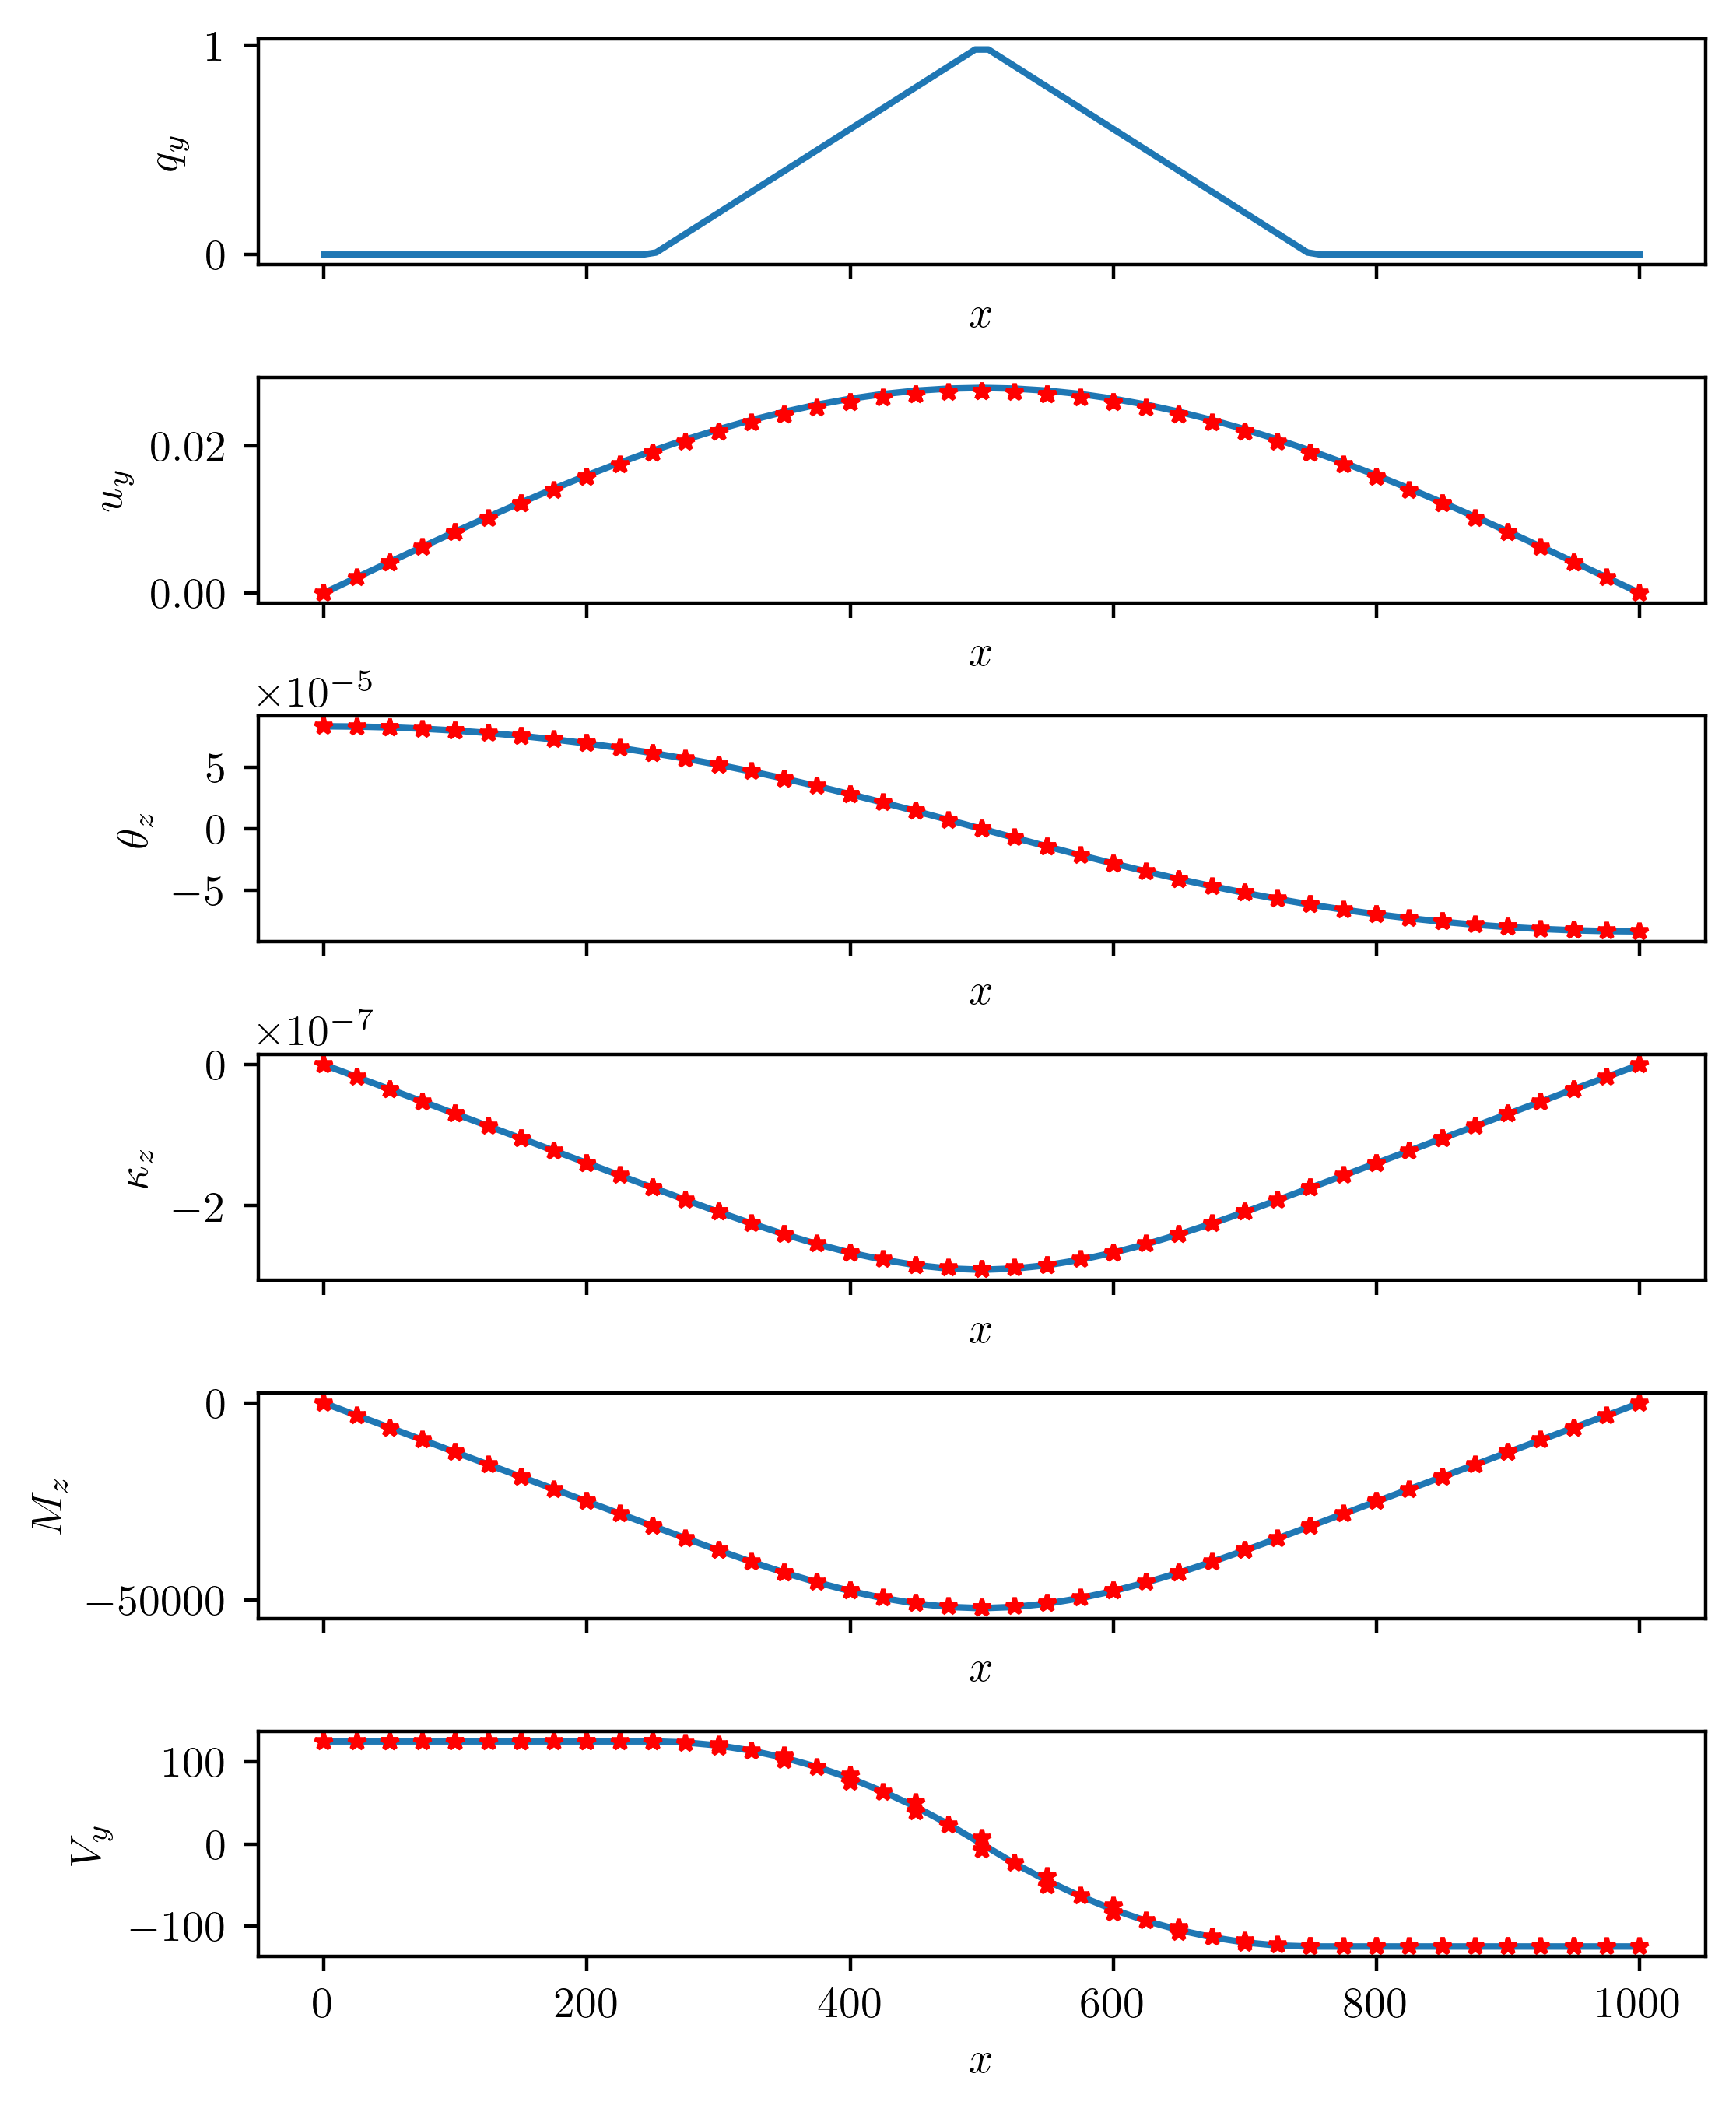

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(6, 8), dpi=400, sharex=True)

_x = np.linspace(0, L, 100)
ms = 4

axs[0].plot(_x, qy(_x))
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$q_y$")

axs[1].plot(x_fem[:, :, 0].flatten(), v_navier)
axs[1].plot(x_fem[:, :, 0].flatten(), u_fem[:, :, 1].flatten(), "r*", markersize=ms)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$u_y$")

axs[2].plot(x_fem[:, :, 0].flatten(), rot_navier)
axs[2].plot(x_fem[:, :, 0].flatten(), u_fem[:, :, -1].flatten(), "r*", markersize=ms)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel(r"$\theta_z$")

axs[3].plot(x_fem[:, :, 0].flatten(), k_navier)
axs[3].plot(x_fem[:, :, 0].flatten(), k_fem[:, :, -1].flatten(), "r*", markersize=ms)
axs[3].set_xlabel("$x$")
axs[3].set_ylabel("$\kappa_z$")

axs[4].plot(x_fem[:, :, 0].flatten(), m_navier)
axs[4].plot(x_fem[:, :, 0].flatten(), f_fem[:, :, -1].flatten(), "r*", markersize=ms)
axs[4].set_xlabel("$x$")
axs[4].set_ylabel("$M_z$")

axs[5].plot(x_fem[:, :, 0].flatten(), f_navier)
axs[5].plot(x_fem[:, :, 0].flatten(), f_fem[:, :, 1].flatten(), "r*", markersize=ms)
axs[5].set_xlabel("$x$")
axs[5].set_ylabel("$V_y$")

plt.subplots_adjust(hspace=0.5)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
    }
)